In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

In [2]:
def landmarks_to_points(landmarks):
    points = []
    for i in range(len(landmarks.parts())):
        points.append((landmarks.part(i).x,landmarks.part(i).y))

    return points

def warp_triangle(img1,img2,tri_in,tri_out):
    rect1 = cv2.boundingRect(tri_in)
    rect2 = cv2.boundingRect(tri_out)

    img1_cropped = img1[rect1[1]:rect1[1] + rect1[3], rect1[0]:rect1[0] + rect1[2]]
    

    tri_in_cropped = []
    tri_out_cropped = []
    for i in range(3):
        tri_in_cropped.append((int(tri_in[0,i,0]-rect1[0]),int(tri_in[0,i,1] - rect1[1])))
        tri_out_cropped.append((int(tri_out[0,i,0]-rect2[0]),int(tri_out[0,i,1] - rect2[1])))

    tri_in_cropped = np.float32(tri_in_cropped).reshape(3,1,2)
    tri_out_cropped = np.float32(tri_out_cropped).reshape(3,1,2)

    warp_mat = cv2.getAffineTransform(tri_in_cropped,tri_out_cropped)

    img2_cropped = cv2.warpAffine(img1_cropped,warp_mat,(rect2[2],rect2[3]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    mask = np.zeros_like(img2_cropped)
    mask = cv2.fillConvexPoly(mask,np.int32(tri_out_cropped),(255,255,255), 16, 0)
    mask = np.float32(mask)/255.0
    img2_cropped = img2_cropped*mask
    img2[rect2[1]:rect2[1]+rect2[3], rect2[0]:rect2[0]+rect2[2]] = img2[rect2[1]:rect2[1]+rect2[3], rect2[0]:rect2[0]+rect2[2]] * ( (1.0, 1.0, 1.0) - mask )

    img2[rect2[1]:rect2[1]+rect2[3], rect2[0]:rect2[0]+rect2[2]] = img2[rect2[1]:rect2[1]+rect2[3], rect2[0]:rect2[0]+rect2[2]] + img2_cropped



def calculate_delaunay(img,points):
    rect = (0,0,img.shape[1],img.shape[0])
    subdiv = cv2.Subdiv2D(rect) 
    for p in points:
        subdiv.insert(p)

    triangles = subdiv.getTriangleList()

    indexes = []
    for tri in triangles:
        pt1 = np.float32([tri[0],tri[1]])
        pt2 = np.float32([tri[2],tri[3]])
        pt3 = np.float32([tri[4],tri[5]])

        index1 = np.argmin(np.sqrt(((np.float32(points) - pt1)**2).sum(axis = 1)),axis = 0)
        index2 = np.argmin(np.sqrt(((np.float32(points) - pt2)**2).sum(axis = 1)),axis = 0)
        index3 = np.argmin(np.sqrt(((np.float32(points) - pt3)**2).sum(axis = 1)),axis = 0)

        indexes.append((index1,index2,index3))

    return indexes

In [27]:
src_image = cv2.imread("../data/images/wrinkle2.jpg")
dst_image = cv2.imread("../data/images/ted_cruz.jpg")

In [28]:
landmark_detector_path = "../data/models/shape_predictor_68_face_landmarks.dat"

face_detector = dlib.get_frontal_face_detector()

landmark_detector = dlib.shape_predictor(landmark_detector_path)


In [29]:
src_image_rgb = cv2.cvtColor(src_image,cv2.COLOR_BGR2RGB)
dst_image_rgb = cv2.cvtColor(dst_image,cv2.COLOR_BGR2RGB)
face_rects_src = face_detector(src_image_rgb,0)
face_rects_dst = face_detector(dst_image_rgb,0)

new_rect_src = dlib.rectangle(int(face_rects_src[0].left()),
                             int(face_rects_src[0].top()),
                             int(face_rects_src[0].right()),
                             int(face_rects_src[0].bottom()))

new_rect_dst = dlib.rectangle(int(face_rects_dst[0].left()),
                             int(face_rects_dst[0].top()),
                             int(face_rects_dst[0].right()),
                             int(face_rects_dst[0].bottom()))

landmarks_src = landmark_detector(src_image_rgb,new_rect_src)
landmarks_dst = landmark_detector(dst_image_rgb,new_rect_dst)

points_src = landmarks_to_points(landmarks_src)
points_dst = landmarks_to_points(landmarks_dst)

In [30]:
offsetScalp = 3.0
brows = [25, 23, 20, 18]
browsReference = [45, 47, 40, 36]

for browPoint, browRefPoint in zip(brows, browsReference):
    foreheadPointX = int(offsetScalp * (points_src[browPoint][0] - points_src[browRefPoint][0]) + points_src[browRefPoint][0])
    foreheadPointY = int(offsetScalp * (points_src[browPoint][1] - points_src[browRefPoint][1]) + points_src[browRefPoint][1])
    points_src.append((foreheadPointX, foreheadPointY))
    
for browPoint, browRefPoint in zip(brows, browsReference):
    foreheadPointX = int(offsetScalp * (points_dst[browPoint][0] - points_dst[browRefPoint][0]) + points_dst[browRefPoint][0])
    foreheadPointY = int(offsetScalp * (points_dst[browPoint][1] - points_dst[browRefPoint][1]) + points_dst[browRefPoint][1])
    points_dst.append((foreheadPointX, foreheadPointY))

In [31]:
indexes = cv2.convexHull(np.array(points_src),returnPoints = False)
hull1 = []
hull2 = []
for i in range(len(indexes)):
    hull1.append(points_src[indexes[i,0]])
    hull2.append(points_dst[indexes[i,0]])

In [32]:
dt = calculate_delaunay(src_image,points_src)

In [33]:
dst_image_copy = dst_image.copy()
for idxs in dt:
    tri_in = []
    tri_out = []
    for idx in idxs:
        tri_in.append(points_src[idx])
        tri_out.append(points_dst
                       [idx])
        
    tri_in = np.float32(tri_in).reshape(1,3,2)
    tri_out = np.float32(tri_out).reshape(1,3,2)
    warp_triangle(src_image,dst_image_copy,tri_in,tri_out)

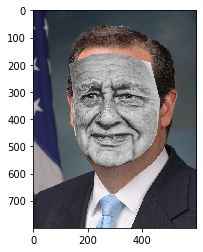

In [34]:
plt.imshow(dst_image_copy[:,:,::-1])

In [35]:
leftEye = [36, 37, 38, 39, 40, 41]
# Right eye polygon
rightEye = [42, 43, 44, 45, 46, 47]
# Mouth polygon
mouth = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
# Nose polygon
nose = [28, 31, 33, 35]

left_eye_pts = []
for pts in rightEye:
    left_eye_pts.append(points_dst[pts]) 

right_eye_pts = []
for pts in leftEye:
    right_eye_pts.append(points_dst[pts])

mouth_pts = []
for pts in mouth:
    mouth_pts.append(points_dst[pts])

nose_pts = []
for pts in nose:
    nose_pts.append(points_dst[pts])
mask = np.zeros_like(dst_image)
cv2.fillConvexPoly(mask,np.int32(hull2),(255,255,255),16,0)
cv2.fillConvexPoly(mask,np.int32(left_eye_pts),(0,0,0),16,0)
cv2.fillConvexPoly(mask,np.int32(right_eye_pts),(0,0,0),16,0)
cv2.fillConvexPoly(mask,np.int32(mouth_pts),(0,0,0),16,0)
cv2.fillConvexPoly(mask,np.int32(nose_pts),(0,0,0),16,0)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [38]:
rect = cv2.boundingRect(np.array(hull2))
print(rect)
centerx = rect[0] + rect[2]//2
centery = rect[1] + rect[3]//2

output = cv2.seamlessClone(dst_image_copy,dst_image,mask,(centerx,centery),cv2.MIXED_CLONE)

(132, 162, 330, 414)


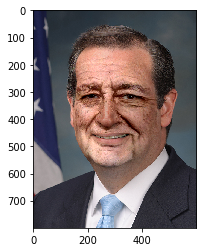

In [39]:
plt.imshow(output[:,:,::-1])